## SCpliceVAE Interactive Test Notebook

#### 1. Setup and Imports

In [1]:
# ==============================================================================
# 1. CLASS DEFINITIONS HERE AND IMPORTS
# ==============================================================================

import os
import sys
import numpy as np
import pandas as pd

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scipy.sparse as sp
from scipy.sparse import csr_matrix, issparse
from collections import defaultdict
import json 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt  # For plotting results
from typing import Dict, List, Optional, Tuple
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import seaborn as sns # For better plotting aesthetics
from umap import UMAP # Import UMAP
from typing import Dict, List, Optional, Tuple
from sklearn.decomposition import PCA

# Ensure the path to your module is in sys.path
# Modify this to point to where your modules are located
module_path = '/gpfs/commons/home/kisaev/multivi_tools_splicing/src/SCplice_vae'  # Change this to your module path
if module_path not in sys.path:
    sys.path.append(module_path)

from dataloaders import * 

from partial_vae import (
    PartialEncoder, 
    LinearDecoder, 
    PartialVAE, 
    binomial_loss_function, 
    beta_binomial_loss_function,
)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


#### 2. Load Some Simulated Data for Testing

In [2]:
# Load AnnData object with simulated single cell splicing data 
# Create synthetic data
adata = ad.read_h5ad('/gpfs/commons/groups/knowles_lab/Karin/TMS_MODELING/DATA_FILES/SIMULATED/simulated_data_2025-03-12.h5ad')

# Basic info about the data
print("\nAnnData Summary:")
print(adata)
print("\nLayers:")
for layer_name, layer in adata.layers.items():
    print(f"  {layer_name}: {type(layer)}, shape {layer.shape}")

# Only keep the layers you're interested in
trimmed_layers = {
    key: adata.layers[key]
    for key in ["junc_ratio", "cell_by_cluster_matrix", "cell_by_junction_matrix"]
}

# Create trimmed AnnData
adata_trimmed = ad.AnnData(
    X=None,  # Don't include full X matrix
    obs=adata.obs.copy(),
    var=adata.var.copy(),
    layers=trimmed_layers
)


AnnData Summary:
AnnData object with n_obs × n_vars = 19942 × 9798
    obs: 'cell_id', 'age', 'batch', 'cell_ontology_class', 'method', 'mouse.id', 'sex', 'tissue', 'old_cell_id_index', 'cell_clean', 'cell_id_index', 'subtissue_clean', 'cell_type_grouped', 'cell_type'
    var: 'junction_id', 'event_id', 'splice_motif', 'label_5_prime', 'label_3_prime', 'annotation_status', 'gene_name', 'gene_id', 'num_junctions', 'position_off_5_prime', 'position_off_3_prime', 'CountJuncs', 'non_zero_count_cells', 'non_zero_cell_prop', 'annotation_status_score', 'non_zero_cell_prop_score', 'splice_motif_score', 'junction_id_index', 'chr', 'start', 'end', 'index', '0', '1', '2', '3', '4', '5', '6', '7', '8', 'sample_label', 'difference', 'true_label'
    uns: 'age_colors', 'cell_type_colors', 'neighbors', 'pca_explained_variance_ratio', 'tissue_colors', 'umap'
    obsm: 'X_leafletFA', 'X_pca', 'X_umap', 'phi_init_100_waypoints', 'phi_init_30_waypoints'
    varm: 'psi_init_100_waypoints', 'psi_init_30_w

/gpfs/commons/home/kisaev/miniconda3/envs/LeafletSC/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


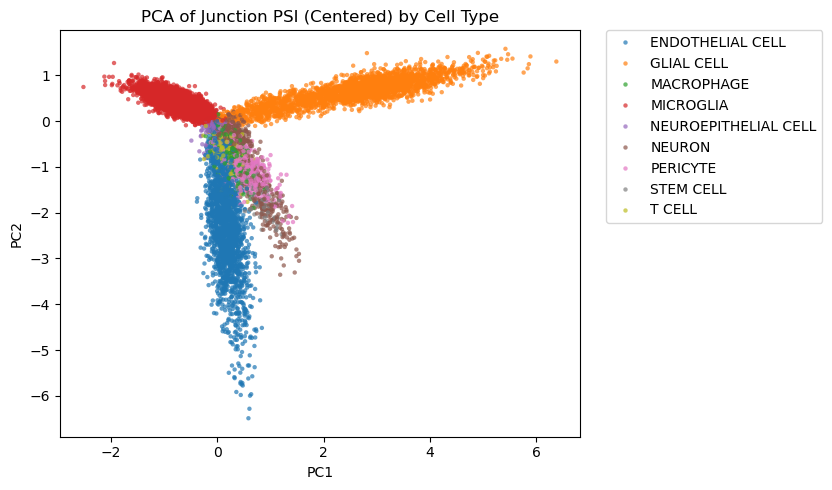

Silhouette Score (cell type, top 10 PCs): 0.2460


In [3]:
# Check if any NaNs in junc_ratio 
X = adata_trimmed.layers["junc_ratio"] 

# Step 1: Compute mean of non-NaN values per column (axis=0)
col_means = np.nanmean(X, axis=0)

# Step 2: Subtract column means from non-NaN entries
X_centered = X - col_means[np.newaxis, :]  # broadcast subtraction

# Step 3: Replace NaNs (which are now just untouched entries) with 0
X_centered[np.isnan(X_centered)] = 0.0

# X should be of shape (num_samples, input_dim)
CODE_DIM = 32  
pca = PCA(n_components=CODE_DIM)
X_pca = pca.fit_transform(X_centered)  # shape: (n_cells, CODE_DIM)
pca_components = pca.components_.T  # shape: (input_dim, code_dim)

# Step 5: Make DataFrame for plotting
df_plot = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "cell_type": adata_trimmed.obs["cell_type"].values
})

# Step 6: Plot
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df_plot,
    x="PC1", y="PC2",
    hue="cell_type",
    s=10, alpha=0.7,
    linewidth=0
)
plt.title("PCA of Junction PSI (Centered) by Cell Type")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

# Encode cell type labels as integers
cell_type_labels = adata_trimmed.obs["cell_type"].values
label_encoder = LabelEncoder()
cell_type_encoded = label_encoder.fit_transform(cell_type_labels)

# Compute silhouette score on PCA space
sil_score = silhouette_score(X_pca[:, :10], cell_type_encoded, metric='euclidean')  # use top 10 PCs
print(f"Silhouette Score (cell type, top 10 PCs): {sil_score:.4f}")

In [18]:
# --- Configuration ---
X_LAYER_NAME = 'junc_ratio'
JUNCTION_COUNTS_LAYER_NAME = 'cell_by_junction_matrix'
CLUSTER_COUNTS_LAYER_NAME = 'cell_by_cluster_matrix'
BATCH_SIZE = 512 # Adjust as needed
NUM_WORKERS = 2 # Adjust based on your system

# --- Create Train/Validation Split ---
all_indices = np.arange(adata_trimmed.n_obs)
train_indices, val_indices = train_test_split(all_indices, test_size=0.2, random_state=42) # 20% validation

# --- Create Datasets ---
train_dataset = AnnDataDataset(
    adata_trimmed,
    x_layer=X_LAYER_NAME,
    junction_counts_layer=JUNCTION_COUNTS_LAYER_NAME,
    cluster_counts_layer=CLUSTER_COUNTS_LAYER_NAME,
    obs_indices=train_indices.tolist() # Pass the list of indices for the training set
)

val_dataset = AnnDataDataset(
    adata_trimmed,
    x_layer=X_LAYER_NAME,
    junction_counts_layer=JUNCTION_COUNTS_LAYER_NAME,
    cluster_counts_layer=CLUSTER_COUNTS_LAYER_NAME,
    obs_indices=val_indices.tolist() # Pass the list of indices for the validation set
)

# --- Create DataLoaders ---
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,         # shuffle training data
    num_workers=NUM_WORKERS,
    pin_memory=True,      # Can speed up CPU->GPU transfer
    drop_last=False       # Keep the last batch even if smaller
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,        # No need to shuffle validation data
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False
)

def compute_mask_density(loader, key='mask'):
    total_ones = 0
    total_elements = 0
    for batch in loader:
        m = batch[key]
        total_ones += m.sum().item()
        total_elements += m.numel()
    print(total_ones)
    print(total_elements)
    return total_ones / total_elements

train_density = compute_mask_density(train_loader)
val_density = compute_mask_density(val_loader)

print(f"Train mask density: {train_density:.3f}")
print(f"Val mask density: {val_density:.3f}")

# --- Get dataset size and number of batches (for loss function scaling) ---
n_train_samples = len(train_dataset)
k_train_batches = len(train_loader)
n_val_samples = len(val_dataset)
k_val_batches = len(val_loader)

print(f"Training samples: {n_train_samples}, Batches: {k_train_batches}")
print(f"Validation samples: {n_val_samples}, Batches: {k_val_batches}")

11077062
156307494
2756475
39084222
Train mask density: 0.071
Val mask density: 0.071
Training samples: 15953, Batches: 32
Validation samples: 3989, Batches: 8


In [ ]:
# ==============================================================================
# 2. CONFIGURATION & HYPERPARAMETERS
# ==============================================================================

# --- Data ---
X_LAYER_NAME = 'junc_ratio'
JUNCTION_COUNTS_LAYER_NAME = 'cell_by_junction_matrix'
CLUSTER_COUNTS_LAYER_NAME = 'cell_by_cluster_matrix'
INPUT_DIM = adata_trimmed.n_vars # Get input dimension from data
print(f"Input Dimension (n_vars): {INPUT_DIM}")

# --- Model Architecture ---
# INPUT_DIM will be set from data
H_HIDDEN_DIM = 64         # Hidden dim for encoder's h_layer 
ENCODER_HIDDEN_DIM = 32  # Hidden dim for encoder's final MLP
LATENT_DIM = 10        # Dimension Z for latent space
DROPOUT_RATE = 0.01

# --- Training ---
LOSS_TYPE = 'binomial' # Choose 'binomial' or 'beta_binomial'
LEARN_CONCENTRATION = False  # Set True for beta-binomial if you want learnable concentration
FIXED_CONCENTRATION = None  # Set to a float (e.g., 10.0) if using beta-binomial with FIXED concentration
                            # If set, overrides LEARN_CONCENTRATION=True

NUM_EPOCHS = 100          # Max number of epochs
LEARNING_RATE = 0.01
PATIENCE = 1             # Early stopping patience (epochs)
SCHEDULE_STEP_SIZE = 10   # LR scheduler step size
SCHEDULE_GAMMA = 0.1      # LR scheduler factor

# --- Output & Logging ---
OUTPUT_DIR = "./vae_training_output" # Directory to save results

# ==============================================================================
# 3. MODEL INITIALIZATION & LOSS FUNCTION SELECTION
# ==============================================================================

# --- Setup Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Instantiate Model ---
# Determine if concentration should be learned based on settings
should_learn_concentration = (LOSS_TYPE == 'beta_binomial') and (FIXED_CONCENTRATION is None) and LEARN_CONCENTRATION
print(f"Learn concentration is set to: {should_learn_concentration}")

model = PartialVAE(
    input_dim=INPUT_DIM,
    code_dim=CODE_DIM,
    h_hidden_dim=H_HIDDEN_DIM,
    encoder_hidden_dim=ENCODER_HIDDEN_DIM,
    latent_dim=LATENT_DIM,
    dropout_rate=DROPOUT_RATE,
    learn_concentration=should_learn_concentration # Pass the determined flag
)

print(f"Initializing feature embeddings using PCA loadings for junctions!")

# Get feature embedding before PCA init
pca_tensor = torch.tensor(pca_components, dtype=model.encoder.feature_embedding.dtype)
embedding_tensor = model.encoder.feature_embedding.detach()
diff = torch.norm(embedding_tensor - pca_tensor).item()
print(f"L2 norm between PCA loadings and random model embedding: {diff:.6f}")

model.initialize_feature_embedding_from_pca(pca_components)
pca_tensor = torch.tensor(pca_components, dtype=model.encoder.feature_embedding.dtype)
embedding_tensor = model.encoder.feature_embedding.detach()
diff = torch.norm(embedding_tensor - pca_tensor).item()
print(f"L2 norm between initialized PCA and model embedding: {diff:.6f}")

print(model)
model.to(device)
print("Model initialized:")
# how to show new emebeddings now that it updated

# --- Choose Loss Function ---
if LOSS_TYPE == 'binomial':
    chosen_loss_function = binomial_loss_function
    print("Using Binomial Loss.")
    if FIXED_CONCENTRATION is not None or LEARN_CONCENTRATION:
         print("Warning: Concentration parameters ignored for binomial loss.")
elif LOSS_TYPE == 'beta_binomial':
    chosen_loss_function = beta_binomial_loss_function
    print("Using Beta-Binomial Loss.")
    if FIXED_CONCENTRATION is not None:
        print(f"Using FIXED concentration: {FIXED_CONCENTRATION}")
    elif should_learn_concentration:
        print("Using LEARNABLE concentration.")
    else:
        print("Warning: Beta-binomial selected but no concentration specified (fixed or learnable). Check config.")
else:
    raise ValueError(f"Unknown LOSS_TYPE: '{LOSS_TYPE}'. Choose 'binomial' or 'beta_binomial'.")

# check the first element in the train dataloader 
for batch in train_loader:
    print("Batch keys:", batch.keys())
    print("Batch shape:", {k: v.shape for k, v in batch.items()})
    break

# ==============================================================================
# 4. TRAINING EXECUTION
# ==============================================================================

# Create output directory if it doesn't exist
if OUTPUT_DIR:
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"Output will be saved to: {os.path.abspath(OUTPUT_DIR)}")

# --- Start Training ---
train_losses, train_recons, train_kls, val_losses, val_recons, val_kls, epochs_trained = model.train_model(
        loss_function=chosen_loss_function,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        num_epochs=NUM_EPOCHS,
        learning_rate=LEARNING_RATE,
        patience=PATIENCE,
        fixed_concentration=FIXED_CONCENTRATION, # Pass the fixed value if set
        schedule_step_size=SCHEDULE_STEP_SIZE,
        schedule_gamma=SCHEDULE_GAMMA,
        output_dir=OUTPUT_DIR,
        # --- Specify keys matching AnnDataDataset output ---
        input_key='x',
        mask_key='mask',
        junction_counts_key='junction_counts',
        cluster_counts_key='cluster_counts'
    )

Input Dimension (n_vars): 9798
Using device: cuda
Learn concentration is set to: False
Initializing feature embeddings using PCA loadings for junctions!
L2 norm between PCA loadings and random model embedding: 559.002258
L2 norm between initialized PCA and model embedding: 0.000000
PartialVAE(
  (encoder): PartialEncoder(
    (h_layer): Sequential(
      (0): Linear(in_features=33, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.01, inplace=False)
      (4): Linear(in_features=64, out_features=32, bias=True)
      (5): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (6): ReLU()
    )
    (encoder_mlp): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.01, inplace=False)
      (4): Linear(in_features=32, out_features=20, bias=True)
    )
  )
  (decoder): LinearDecod

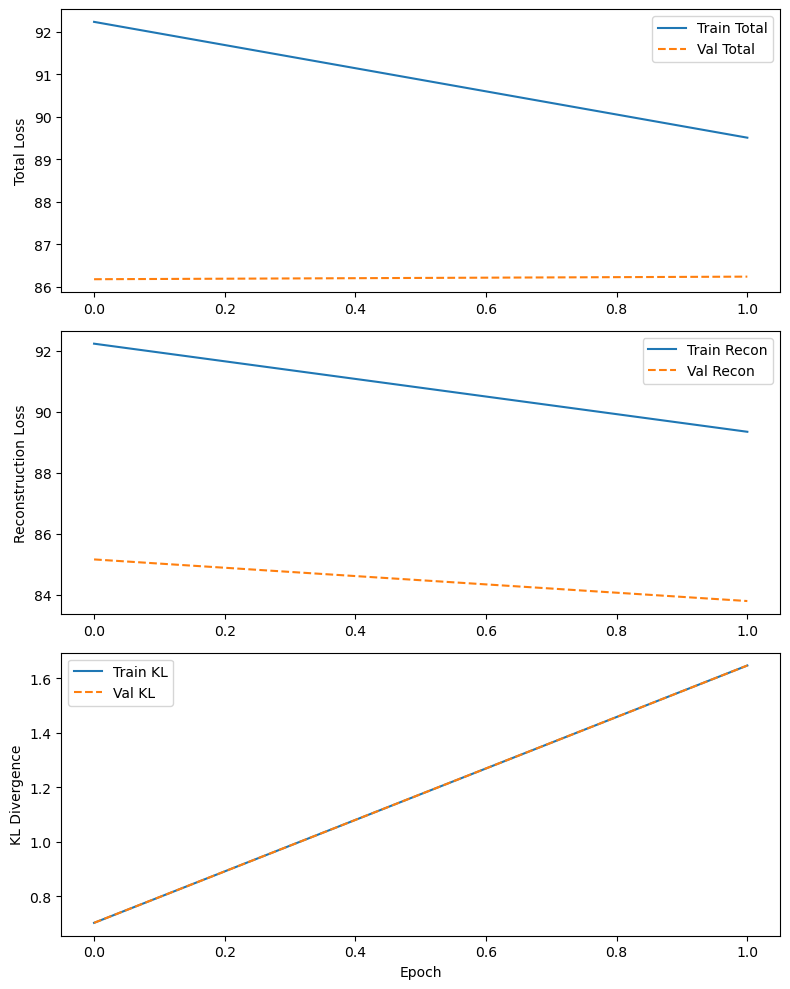

In [ ]:
epochs = list(range(len(train_recons)))
train_recons_np = [x.cpu().item() if isinstance(x, torch.Tensor) else x for x in train_recons]
val_recons_np = [x.cpu().item() if isinstance(x, torch.Tensor) else x for x in val_recons]
train_kls_np = [x.cpu().item() if isinstance(x, torch.Tensor) else x for x in train_kls]

fig, axes = plt.subplots(3, 1, figsize=(8, 10))

axes[0].plot(epochs, train_losses, label="Train Total")
axes[0].plot(epochs, val_losses, label="Val Total", linestyle="--")
axes[0].set_ylabel("Total Loss")
axes[0].legend()

axes[1].plot(epochs, train_recons_np, label="Train Recon")
axes[1].plot(epochs, val_recons_np, label="Val Recon", linestyle="--")
axes[1].set_ylabel("Reconstruction Loss")
axes[1].legend()

axes[2].plot(epochs, train_kls_np, label="Train KL")
axes[2].plot(epochs, train_kls_np, label="Val KL", linestyle="--")
axes[2].set_ylabel("KL Divergence")
axes[2].set_xlabel("Epoch")
axes[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
# --- Select cells to embed ---
indices_to_use = np.arange(adata.n_obs)
print(f"Getting latent representations for {len(indices_to_use)} cells...")

CELL_TYPE_COLUMN = "cell_type"
cell_labels = adata.obs[CELL_TYPE_COLUMN][indices_to_use].astype(str).values

# --- Create Dataset and DataLoader for Inference ---
inference_dataset = AnnDataDataset(
    adata,
    x_layer=X_LAYER_NAME,
    junction_counts_layer=JUNCTION_COUNTS_LAYER_NAME,
    cluster_counts_layer=CLUSTER_COUNTS_LAYER_NAME,
    obs_indices=indices_to_use.tolist()
)

inference_loader = DataLoader(
    inference_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False
)

# --- Encode latent representations (Z matrix) ---
latent_reps_list = []
model.eval()  # make sure in eval mode
with torch.no_grad():
    for i, batch in enumerate(inference_loader):
        x_batch = batch['x'].to(device)
        mask_batch = batch['mask'].to(device)
        latent_batch_np = model.get_latent_rep(x_batch, mask_batch)
        latent_reps_list.append(latent_batch_np)

all_latent_reps = np.concatenate(latent_reps_list, axis=0)
print(f"Finished collecting latent representations (shape={all_latent_reps.shape}).")

# --- Extract model weights ---
decoder_weight = model.decoder.linear.weight.detach().cpu().numpy()  # (n_junctions, latent_dim)
decoder_bias = model.decoder.linear.bias.detach().cpu().numpy()      # (n_junctions,)
feature_embeddings = model.get_features()                            # (n_junctions, code_dim)

# --- Save into AnnData object ---
adata.obsm["X_SCpliceVAE"] = all_latent_reps
adata.varm["decoder_weight"] = decoder_weight
adata.varm["feature_embeddings"] = feature_embeddings

print("Latent representations, decoder matrix, and feature embeddings saved to AnnData.")

Getting latent representations for 19942 cells...


/scratch/ipykernel_3068842/3358426504.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell_labels = adata.obs[CELL_TYPE_COLUMN][indices_to_use].astype(str).values


Finished collecting latent representations (shape=(19942, 10)).
Latent representations, decoder matrix, and feature embeddings saved to AnnData.


Running UMAP for dimensionality reduction...


/gpfs/commons/home/kisaev/miniconda3/envs/LeafletSC/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/gpfs/commons/home/kisaev/miniconda3/envs/LeafletSC/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Shape of 2D UMAP embedding: (19942, 2)
2D UMAP embedding saved into adata.obsm['X_umap_SCpliceVAE'].


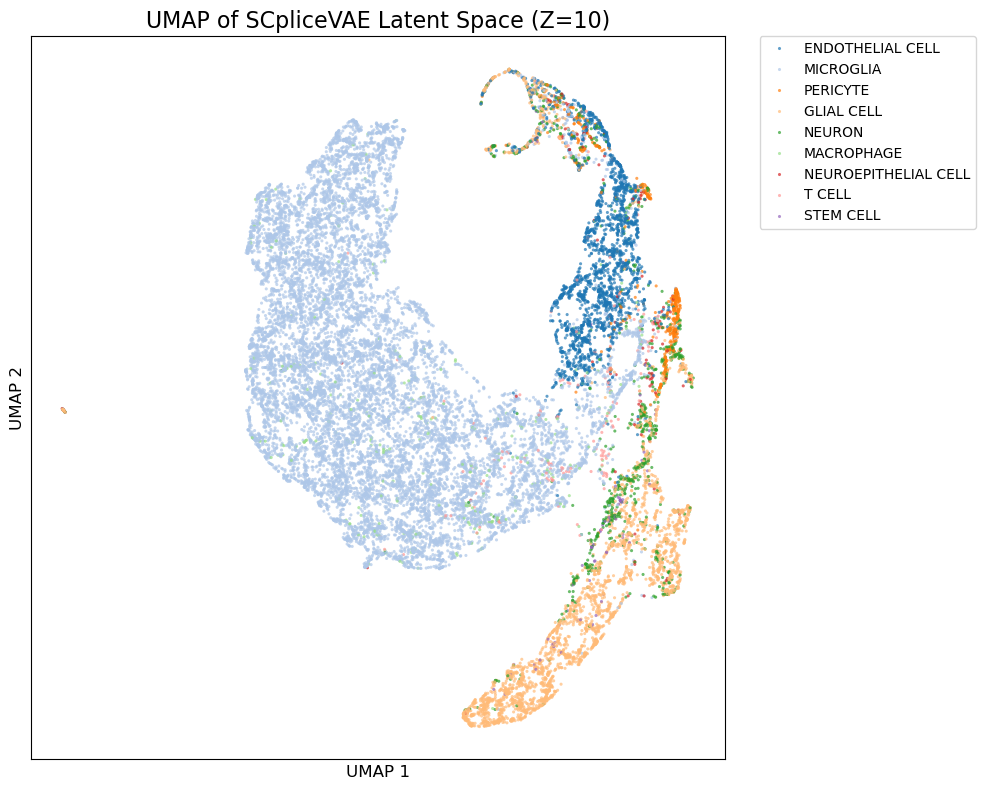

In [ ]:
# ==============================================================================
# 5. DIMENSIONALITY REDUCTION (UMAP)
# ==============================================================================

# --- Visualization ---
# UMAP parameters (can be tuned)
N_NEIGHBORS = 8
MIN_DIST = 0.1
UMAP_METRIC = 'euclidean' # Distance metric in latent space

print("Running UMAP for dimensionality reduction...")
reducer = UMAP(
    n_components=2,       # Reduce to 2 dimensions for plotting
    n_neighbors=N_NEIGHBORS,    # Controls local vs global structure (adjust)
    min_dist=MIN_DIST,      # Controls tightness of clusters (adjust)
    metric=UMAP_METRIC,     # Distance metric in the latent space
    random_state=42       # For reproducibility
)

embedding_2d = reducer.fit_transform(all_latent_reps)
print(f"Shape of 2D UMAP embedding: {embedding_2d.shape}") # Should be (n_obs, 2)

# Save UMAP embedding into AnnData for easier reuse later
adata.obsm["X_umap_SCpliceVAE"] = embedding_2d

print("2D UMAP embedding saved into adata.obsm['X_umap_SCpliceVAE'].")

# --- Plot UMAP ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))

num_unique_labels = len(np.unique(cell_labels))
palette = sns.color_palette('tab20', n_colors=num_unique_labels)

sns.scatterplot(
    x=embedding_2d[:, 0],
    y=embedding_2d[:, 1],
    hue=cell_labels,
    palette=palette,
    s=5,
    alpha=0.7,
    linewidth=0
)

plt.title(f"UMAP of SCpliceVAE Latent Space (Z={LATENT_DIM})", fontsize=16)
plt.xlabel('UMAP 1', fontsize=12)
plt.ylabel('UMAP 2', fontsize=12)
plt.xticks([])
plt.yticks([])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)  # move legend outside
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

# 1. Get latent embeddings (already saved)
X = adata.obsm["X_SCpliceVAE"]  # shape (n_cells, latent_dim)

# 2. Get cell_type labels
labels = adata.obs["cell_type"].astype(str).values

# 3. Calculate silhouette score
score = silhouette_score(X, labels, metric='euclidean')
print(f"Silhouette score based on SCpliceVAE latent space: {score:.4f}")

Silhouette score based on SCpliceVAE latent space: -0.0083


In [ ]:
def plot_top_junctions_per_latent(adata, decoder_key="decoder_weight", top_k=10):
    decoder_weight = adata.varm[decoder_key]  # shape (n_junctions, latent_dim)
    junction_names = adata.var["junction_id"].values  # or "gene_name" if you prefer

    for latent_dim in range(decoder_weight.shape[1]):
        print(f"\nTop {top_k} junctions for latent dimension {latent_dim}:")
        
        # Get the weights for this latent dimension
        weights = decoder_weight[:, latent_dim]
        top_indices = np.argsort(np.abs(weights))[::-1][:top_k]
        
        for rank, idx in enumerate(top_indices):
            print(f"  {rank+1}. {junction_names[idx]} (weight={weights[idx]:.4f})")

plot_top_junctions_per_latent(adata, decoder_key="decoder_weight", top_k=10)


Top 10 junctions for latent dimension 0:
  1. chr5_73300717_73303591_+ (weight=-0.3463)
  2. chr11_50159711_50162045_+ (weight=-0.3463)
  3. chr1_74380997_74381735_+ (weight=-0.3462)
  4. chr5_135388717_135391621_- (weight=-0.3453)
  5. chr6_29709998_29710589_+ (weight=0.3453)
  6. chr11_78470851_78471370_+ (weight=-0.3439)
  7. chr14_21847923_21848001_- (weight=0.3436)
  8. chr3_96722625_96723513_- (weight=-0.3435)
  9. chr17_25153154_25153560_+ (weight=-0.3431)
  10. chr5_140427567_140430051_+ (weight=-0.3427)

Top 10 junctions for latent dimension 1:
  1. chr18_36677505_36678393_- (weight=0.3181)
  2. chr10_7703120_7705459_+ (weight=0.3141)
  3. chr14_30951718_30953802_+ (weight=0.3117)
  4. chr10_80061447_80062161_- (weight=0.3108)
  5. chr5_22500088_22516703_- (weight=0.3100)
  6. chr7_25722997_25724554_- (weight=0.3098)
  7. chr11_60464891_60468063_+ (weight=0.3098)
  8. chr13_96549331_96571910_+ (weight=0.3095)
  9. chr12_85917774_85918930_+ (weight=-0.3095)
  10. chr17_2514779